### This is part of the revision of the paper to look at the coverage analysis of certain published Pst and Psh genomes


The inital input genomes are derived from the following accesion numbers:
* SBIN00000000 (diploid assembly of Pst)
* SAMN08200485 (primary assembly of Pst)
* SAMN08200486 (primary assembly of Psh)

These are the only available consistent genomes 20200129 when compared to the quality of Pst-104E and DK0911.  


The corresponding short reads come from SRA as follows:
* SRR9825536
* SRR8208848
* SRR8208849



The following step need to be done:
* Trim input data with trimmomatic
* map with bwa
* for the diploid assembly some Assembletics mapping needs to be done from haplotigs on primary contigs to generate the WGS overlap bed file
* for all assemblies the coverage distributions need to be plotted

This notebook is aimed at calculating the coverage of the genome using short read illumina data mapped with bwa againts primary contigs and primary contigs + haplotigs.

* calculate the coverage in 1000 bp sliding windows (200bp) for p and p+h mapping.
* calculate the coverage when mapping against primary contigs in regions with h overlap and without
* plot those out and see the coverage distributions

In [1]:
%matplotlib inline

In [7]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import tempfile
from scipy.signal import argrelextrema
import scipy
from het_cov import *
import importlib
import subprocess

In [81]:
import het_cov
importlib.reload(het_cov)
from het_cov import *

In [159]:
RAW_READ_DIR = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data'
TRIM_DIR = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads'
GENOMES_DIR = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/genomes'
MAPPING_DIR = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/mapping'
COV_DIR = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov'
FIGURE_DIR = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/figures'
adapter_fn = os.path.join(TRIM_DIR, 'adapters.fa')


In [160]:
!mkdir {FIGURE_DIR}

In [62]:
!mkdir /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov

In [56]:
input_fastq = [os.path.join(RAW_READ_DIR,x) for x in os.listdir(RAW_READ_DIR) if x.endswith('.fq') or x.endswith('.fastq')]
input_fastq.sort()

['/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/S150_1.fq',
 '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/S150_2.fq',
 '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/SRR8208848_1.fastq',
 '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/SRR8208848_2.fastq',
 '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/SRR8208849_1.fastq',
 '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/SRR8208849_2.fastq']

In [64]:
trim_cmd = 'trimmomatic PE -threads 20 %s %s %s.paired.gz %s.unpaired.gz %s.paired.gz %s.unpaired.gz \
ILLUMINACLIP:adapters.fa:2:30:10:2:keepBothReads LEADING:3 TRAILING:3 MINLEN:36'

In [66]:
#trimming
for n in range(0, len(input_fastq), 2):
    #print(n)
    fb = os.path.join(TRIM_DIR, os.path.basename(input_fastq[n]).split('.')[0])
    rb = os.path.join(TRIM_DIR, os.path.basename(input_fastq[n+1]).split('.')[0])
    cmd = trim_cmd % (input_fastq[n], input_fastq[n+1], fb, fb, rb, rb )
    print(cmd)
    output = subprocess.run(cmd, shell=True)
    print(output.returncode)

trimmomatic PE -threads 20 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/S150_1.fq /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/S150_2.fq /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/S150_1.paired.gz /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/S150_1.unpaired.gz /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/S150_2.paired.gz /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/S150_2.unpaired.gz ILLUMINACLIP:adapters.fa:2:30:10:2:keepBothReads LEADING:3 TRAILING:3 MINLEN:36
0
trimmomatic PE -threads 20 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/SRR8208848_1.fastq /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/raw_data/SRR8208848_2.fastq /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/SRR8208848_1

In [33]:
#pull out primaries and haplotigs from SBIN01.1.fsa_nt
primaries = []
haplotigs = []
for seq in SeqIO.parse(os.path.join(GENOMES_DIR, 'SBIN01.1.fsa_nt'), 'fasta'):
    if int(seq.id.split('.')[0][-4:]) < 382:
        primaries.append(seq)
    elif int(seq.id.split('.')[0][-4:]) > 381:
        haplotigs.append(seq)

In [36]:
SeqIO.write(primaries, os.path.join(GENOMES_DIR, 'SBIN01.1.p_conigs.fsa_nt'), 'fasta')
SeqIO.write(haplotigs, os.path.join(GENOMES_DIR, 'SBIN01.1.h_conigs.fsa_nt'), 'fasta')

873

In [58]:
for x in os.listdir(GENOMES_DIR):
    if x.endswith('fsa_nt'):
        print(x)

SBIN01.1.fsa_nt
SBIN01.1.h_conigs.fsa_nt
PKSL01.1.fsa_nt
PKSM01.1.fsa_nt
SBIN01.1.p_conigs.fsa_nt


In [59]:
mapping_dict = {'SBIN01.1.fsa_nt' : 'S150', 'SBIN01.1.p_conigs.fsa_nt' : 'S150',\
                'PKSL01.1.fsa_nt': 'SRR8208848',\
               'PKSM01.1.fsa_nt': 'SRR8208849'}

In [67]:
#now get paired reads and do the mapping
paired_reads = [os.path.join(TRIM_DIR, x) for x in os.listdir(TRIM_DIR) if x.split('.')[1] == 'paired']
bwa_cmd = 'bwa mem -t 20 %s %s %s | samtools sort -@ 20 -O BAM -o %s -'
bam_dict = {}
for ref, read_id in mapping_dict.items():
    bam_fn = os.path.join(MAPPING_DIR, '%s.%s.bam' % (ref, read_id))
    reads = [x for x in paired_reads if os.path.basename(x).split('_')[0] == read_id]
    reads.sort()
    cmd = bwa_cmd % (os.path.join(GENOMES_DIR, ref), reads[0], reads[1], bam_fn)
    print(cmd)
    output = subprocess.run(cmd, shell=True)
    if output.returncode == 0:
        bam_dict[ref] = bam_fn
    print(output.returncode)  

bwa mem -t 20 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/genomes/PKSM01.1.fsa_nt /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/SRR8208849_1.paired.gz /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/SRR8208849_2.paired.gz | samtools sort -@ 20 -O BAM -o /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/mapping/PKSM01.1.fsa_nt.SRR8208849.bam -
0
bwa mem -t 20 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/genomes/SBIN01.1.fsa_nt /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/S150_1.paired.gz /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/trimmed_reads/S150_2.paired.gz | samtools sort -@ 20 -O BAM -o /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/mapping/SBIN01.1.fsa_nt.S150.bam -
0
bwa mem -t 20 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revi

In [98]:
genome_fn_dict['Pst_104E_v13_p_ctg.fa'] = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/genomes/Pst_104E_v13_p_ctg.genome_file'
genome_fn_dict['DK_0911_v04_p_ctg.fa'] = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/genomes/DK_0911_v04_p_ctg.genome_file'

In [105]:
bam_dict['DK_0911_v04_p_ctg.fa'] = os.path.join(MAPPING_DIR, 'DK_0911_v04_p_ctg.DK0911_SR.bam')
bam_dict['Pst_104E_v13_p_ctg.fa'] = os.path.join(MAPPING_DIR, 'Pst_104E_v13_p_ctg.Pst_104E_SR.bam')

In [ ]:
#need to generate fadix files for genomes
#need to generate windows files
#need to calculate coverage

In [ ]:
genome_fn_dict = {}
window_fn_dict = {}
samcov_fn_dict = {}

In [103]:
#indexing and windows file
for genome in mapping_dict.keys():
    g_fasta_fn = os.path.join(GENOMES_DIR, genome)
    genome_fn_dict[genome] = os.path.join(GENOMES_DIR, genome.replace('.fsa_nt', '.genome_file'))
    faidx_genome(genome_fn_dict[genome], g_fasta_fn)
    #windows file 
    window_fn_dict[genome] = os.path.join(COV_DIR, genome.replace('.fsa_nt', '.window_1k200.bed'))
    BedTool().window_maker(g=genome_fn_dict[genome], w=1000, s=200).saveas(window_fn_dict[genome])
    samcov_fn_dict[genome] = os.path.join(COV_DIR, genome.replace('.fsa_nt', '.window_1k200.cov'))
    run_sam_bedcov(window_fn_dict[genome],bam_dict[genome], samcov_fn_dict[genome], parallel=20)

/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/genomes/PKSM01.1.genome_file already exists!
in_file_line_number: 387121
target chunk_size: 19356

Runnning now!

Runnning now!

Runnning now!

Runnning now!



Runnning now!

Runnning now!

samtools bedcov /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/PKSM01.1.window_1k200.bed_0 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/mapping/PKSM01.1.fsa_nt.SRR8208849.bam > /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/PKSM01.1.window_1k200.cov_0

samtools bedcov /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/PKSM01.1.window_1k200.bed_1 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/mapping/PKSM01.1.fsa_nt.SRR8208849.bam > /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/PKSM01.1.window_1k200.cov_1

samtools bedcov /home/benjamin/genome_assembl

Process ForkPoolWorker-188:
Traceback (most recent call last):
  File "/home/benjamin/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/benjamin/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/benjamin/anaconda3/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/benjamin/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
  File "/home/benjamin/anaconda3/lib/python3.5/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/benjamin/anaconda3/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/benjamin/anaconda3/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [109]:
for genome in ['Pst_104E_v13_p_ctg.fa', 'DK_0911_v04_p_ctg.fa']:
    g_fasta_fn = os.path.join(GENOMES_DIR, genome)
    genome_fn_dict[genome] = os.path.join(GENOMES_DIR, genome.replace('.fa', '.genome_file'))
    faidx_genome(genome_fn_dict[genome], g_fasta_fn)
    #windows file 
    window_fn_dict[genome] = os.path.join(COV_DIR, genome.replace('.fa', '.window_1k200.bed'))
    BedTool().window_maker(g=genome_fn_dict[genome], w=1000, s=200).saveas(window_fn_dict[genome])
    samcov_fn_dict[genome] = os.path.join(COV_DIR, genome.replace('.fa', '.window_1k200.cov'))
    run_sam_bedcov(window_fn_dict[genome],bam_dict[genome], samcov_fn_dict[genome], parallel=20)

/home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/genomes/Pst_104E_v13_p_ctg.genome_file already exists!
in_file_line_number: 416859
target chunk_size: 20842

Runnning now!

Runnning now!

Runnning now!

Runnning now!

Runnning now!



Runnning now!

Runnning now!



Runnning now!

samtools bedcov /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/Pst_104E_v13_p_ctg.window_1k200.bed_0 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/mapping/Pst_104E_v13_p_ctg.Pst_104E_SR.bam > /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/Pst_104E_v13_p_ctg.window_1k200.cov_0

Runnning now!

Runnning now!
samtools bedcov /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/Pst_104E_v13_p_ctg.window_1k200.bed_1 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/mapping/Pst_104E_v13_p_ctg.Pst_104E_SR.bam > /home/benjamin/genome_assembly/Warrior/DK0911


Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Done
With ouput:
b''
b''

Runnning now!

cat /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/Pst_104E_v13_p_ctg.window_1k200.cov_0 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/Pst_104E_v13_p_ctg.window_1k200.cov_1 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/Pst_104E_v13_p_ctg.window_1k200.cov_2 /home/benjamin/genome_assembly/Warrior/DK0911_v04/revisions_v01/het-cov/cov/tmp/

In [90]:
#histogram of 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)
sns.set_style("ticks")
sns.despine()
pallete = sns.color_palette('colorblind')


SBIN01.1.p_conigs.fsa_nt
These are the options for the peaks that are greater than 10% of the max peak.
              index  ave_cov     mids
0   (-0.171, 0.855]     3651   0.3420
25  (21.375, 22.23]     8794  21.8025
50  (42.75, 43.605]    16314  43.1775
This is the calculated haploid coverage: 21.803000
PKSL01.1.fsa_nt
These are the options for the peaks that are greater than 10% of the max peak.
             index  ave_cov    mids
25  (25.25, 26.26]     7048  25.755
49   (49.49, 50.5]    14008  49.995
This is the calculated haploid coverage: 25.755000
PKSM01.1.fsa_nt
These are the options for the peaks that are greater than 10% of the max peak.
              index  ave_cov     mids
24  (22.44, 23.375]     5996  22.9075
45  (42.075, 43.01]    16441  42.5425
This is the calculated haploid coverage: 22.908000
SBIN01.1.fsa_nt
These are the options for the peaks that are greater than 10% of the max peak.
             index  ave_cov    mids
0   (-0.116, 0.58]     5304   0.232
36  (20.88, 

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


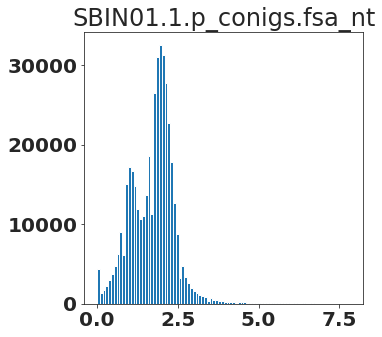

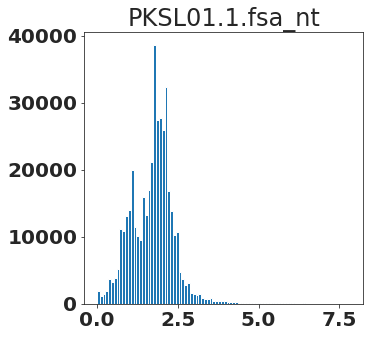

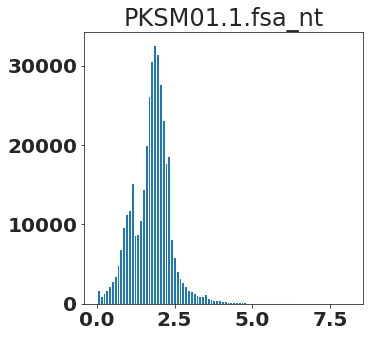

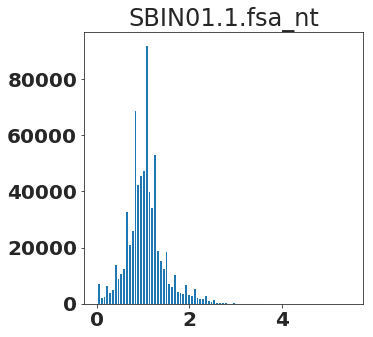

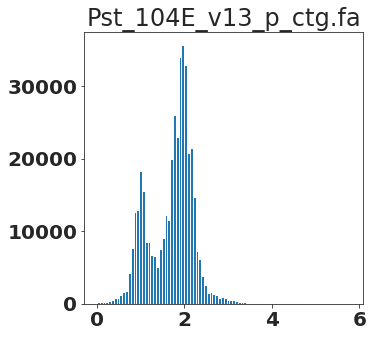

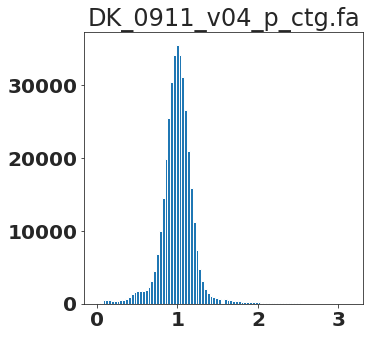

In [126]:
samcov_df_dict = {}
bins = 90
for genome in samcov_fn_dict.keys():
    print(genome)
    samcov_df_dict[genome] = samcov_slurp(samcov_fn_dict[genome], quantile = 0.98, norm = True, contig_fil=False)
    fig, ax = plt.subplots(figsize=(5,5), sharex='all', sharey='all')
    ax.hist(samcov_df_dict[genome].norm_cov, bins=bins)
    plt.title(genome)

In [157]:
#fix this up using the previous estimated haploid coverage which was really the diploid coverage and was caught 
#by the program.
samcov_df_dict['DK_0911_v04_p_ctg.fa'] = samcov_slurp(samcov_fn_dict['DK_0911_v04_p_ctg.fa'], quantile = 0.98, norm =14, contig_fil=False)

In [116]:
subplots_index = []
for x in range(0,int(len(samcov_fn_dict.keys())/2)):
    for y in range(0,2):
        subplots_index.append([x,y])

In [154]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Pst_104E_v13_p_ctg.fa
DK_0911_v04_p_ctg.fa
PKSL01.1.fsa_nt
SBIN01.1.p_conigs.fsa_nt
PKSM01.1.fsa_nt


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


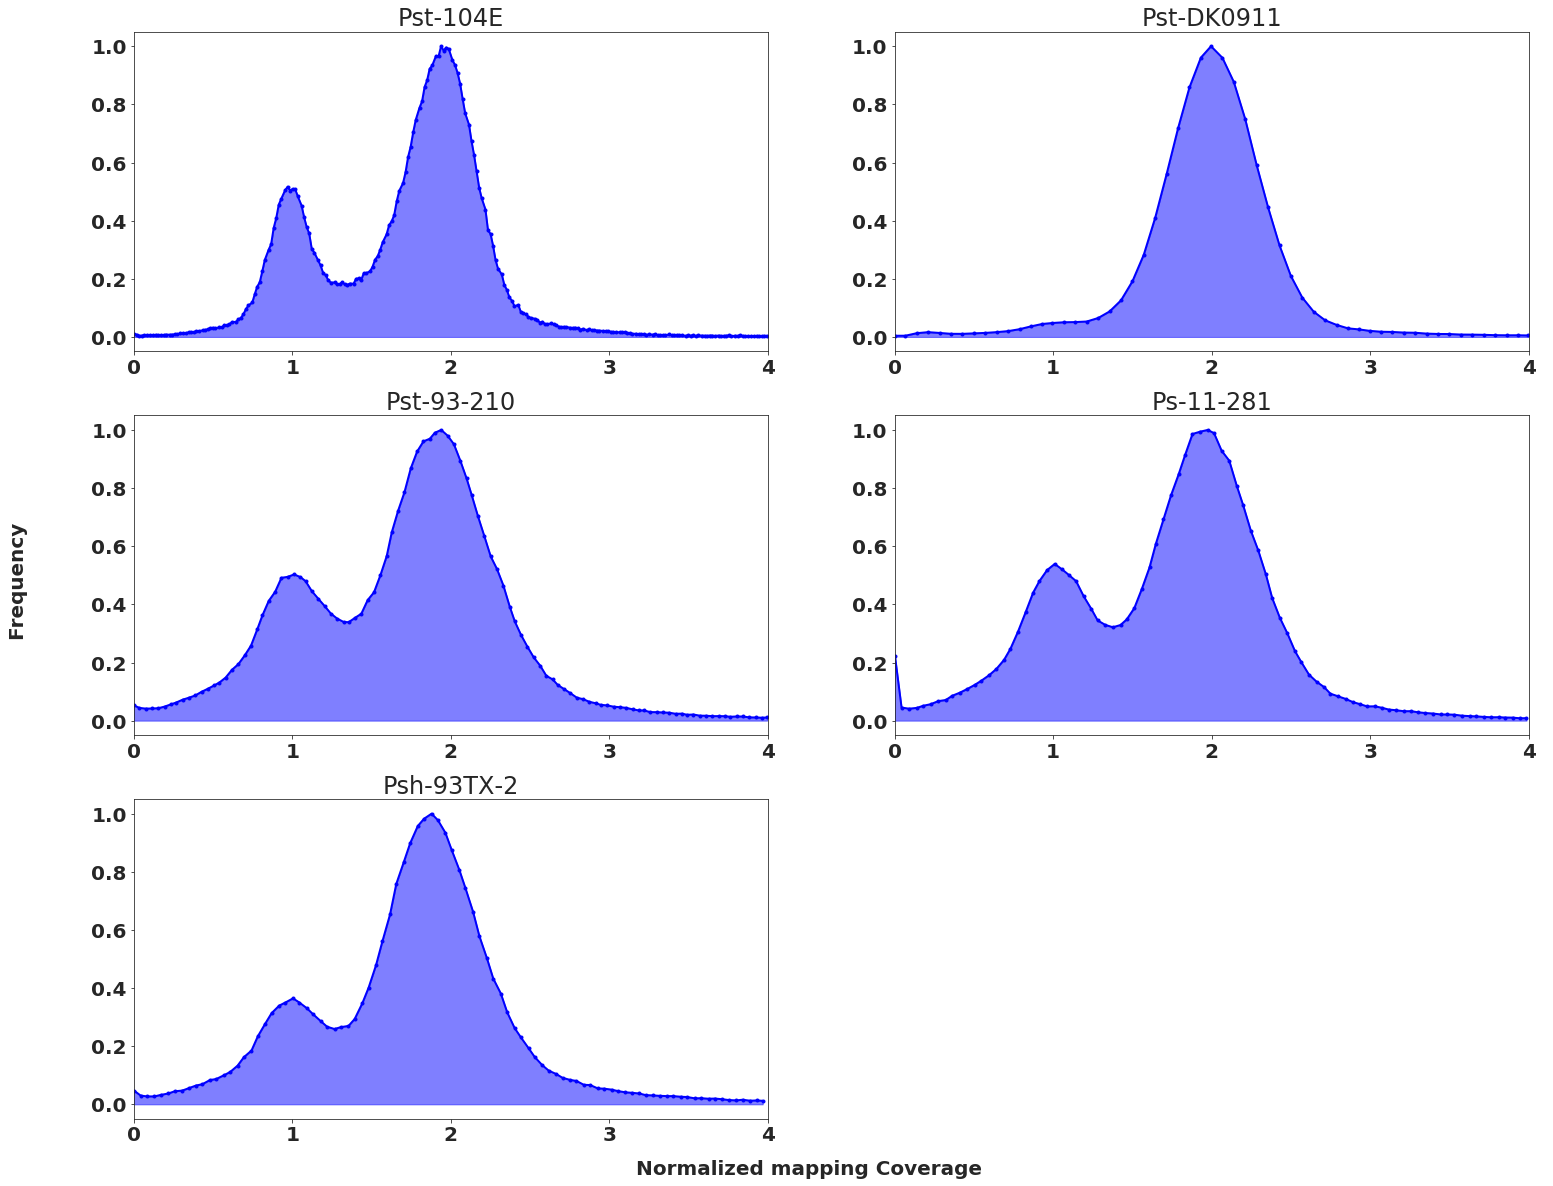

In [161]:
fig, ax = plt.subplots(3, 2, figsize=(25,20))

fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.09, 'Normalized mapping Coverage',ha='center', va='center')

plot_genome_list = ['Pst_104E_v13_p_ctg.fa', 'DK_0911_v04_p_ctg.fa', 'PKSL01.1.fsa_nt',\
                    'SBIN01.1.p_conigs.fsa_nt' ,  'PKSM01.1.fsa_nt']
plot_name_list = ['Pst-104E', 'Pst-DK0911', 'Pst-93-210', 'Ps-11-281', 'Psh-93TX-2']

bins = 60

for n, genome in enumerate(plot_genome_list):
    df = samcov_df_dict[genome]
    if genome == 'SBIN01.1.fsa_nt':
        continue
    else:
        df = df[(df.norm_cov <= 4)]
        bin_df = bin_value_filter_df(df)
        print(genome)
        tmp_ax = ax[subplots_index[n][0], subplots_index[n][1]]
        fill_plot_axis(bin_df.mids.tolist(), bin_df.norm_freq.tolist(),\
                       ax = tmp_ax, color = 'b')
        
        tmp_ax.set_title(plot_name_list[n])
        tmp_ax.set_xlim(0,4)
        tmp_ax.xaxis.set_major_locator(MultipleLocator(1))

ax[subplots_index[n+1][0], subplots_index[n+1][1]].axis('off')    

out_fn = os.path.join(FIGURE_DIR, '%s_SRM_coverage.png' % 'Ps_self')


fig.savefig(out_fn, dpi=600)
#ax1[0,0].set_xlim([0,max_norm_cov])
#ax1[2,0].hist(samcov, bins=bins, color=pallete[2])